<a href="https://colab.research.google.com/github/curtiscu/MScCode/blob/main/2020_12_15_GridSearchCV_kNN_BoostedTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General note on running models



I initially ran GridSearchCV on the whole X,y dataset (i.e. ignoring X_train/ y_train, X_test/ y_test) and spat out the best results without evaluation on unseen data. See...
* See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

i.e. With GridSearchCV, I need to..
* setup model
* fit with X_train/ y_train
* evaluate and find best model
* take best model and use X_test/ y_test on it

Also from...
* https://stackoverflow.com/a/55605798

"Internally, GridSearchCV splits the dataset given to it into various training and validation subsets, and, using the hyperparameter grid provided to it, finds the single set of hyperparameters that give the best score on the validation subsets.

The point of a train-test split is then, after this process is done, to perform one final scoring on the test data, which has so far been unknown to the model, to see if your hyperparameters have been overfit to the validation subsets. If it does well, then the next step is putting the model into production/deployment."

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
#!pip uninstall scikit-learn -y
#!pip install scikit-learn
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.0)


In [2]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [3]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
home_dir = '/content/drive/My Drive/'

In [5]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 57
-rw------- 1 root root 33746 Dec 29 00:21 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [6]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [7]:
# regular imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# object that provides colours for charts
from itertools import cycle

# sklearn imports
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [8]:
# install required libs
!pip install mido

     |████████████████████████████████| 61kB 2.9MB/s 


In [9]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2021-01-01 17:03:23.356649, module name: stats_n_features
>> LOADING custom module, when: 2021-01-01 17:03:23.357878, module name: data_prep
>> LOADING custom module, when: 2021-01-01 17:03:23.630751, module name: pipeline_utils


In [10]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

Test function in data_prep.py called and worked! when: 2021-01-01 17:03:23.662003,  param:bling
Test function in stats_n_features called and worked! when: 2021-01-01 17:03:23.662383,  param:hello


## Pandas display options

In [11]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [ ]:
##################################
######## LOAD

my_data = dp.load_all_data()
all_drummer_data = my_data.copy()
;

In [13]:
logs_df = dp.get_last_logs()
display(logs_df.head(3))
filtered_logs_df = logs_df[['style', 'tempo_us', 'tempo_bpm', 'ts_num', 'ts_den', 'PPQN', 'bars_in_file', 'ticks_per_bin', 'ms_per_bin']]
#check_stats_df = filtered_logs_df.groupby('style').agg([pd.Series.mode, 'nunique'])
check_stats_df = filtered_logs_df.groupby('style').agg([pd.Series.mode])
check_stats_df.columns = check_stats_df.columns.droplevel(1)
#check_stats_df.to_csv(r'/content/drive/My Drive/check_stats_df.csv')
display(check_stats_df)

,file_name,style,drummer,file_type,ts_num,ts_den,tempo_us,tempo_bpm,PPQN,first_hit,last_hit,bars_in_file,quantize_level,ticks_per_beat,ticks_per_bin,ms_per_bin,err_buckets
0,drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid,funk/groove1,drummer1,0,4,4,434783,137.999876,480,3,30658,16,16.0,480.0,120,0.108696,"(24, 13)"
1,drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid,soul/groove3,drummer1,0,4,4,697674,86.000052,480,0,30696,16,16.0,480.0,120,0.174419,"(8, 13)"
2,drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid,soul/groove4,drummer1,0,4,4,750000,80.000000,480,0,30470,16,16.0,480.0,120,0.187500,"(0, 13)"


,tempo_us,tempo_bpm,ts_num,ts_den,PPQN,bars_in_file,ticks_per_bin,ms_per_bin
style,,,,,,,,
funk/groove1,434783,137.999876,4,4,480,16,120,0.108696
hiphop/groove6,689655,87.000022,4,4,480,16,120,0.172414
rock/groove8,923077,64.999995,4,4,480,16,120,0.230769
soul/groove3,697674,86.000052,4,4,480,16,120,0.174419
soul/groove4,750000,80.000000,4,4,480,16,120,0.187500


In [14]:
# new method of loading data..
master_df = all_drummer_data['master_df']

In [15]:
# example file specific file_df
#file_bundle = all_drummer_data['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid']
#file_bundle.tight_df


## Filter songs...

Take a look at all file names in the complete data set...

In [16]:
list(all_drummer_data.keys())

['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.m

In [17]:
# compare to new method of loading data..
master_df.head(10)

,drummer_ID,note,velocity,beat_offset,beat_offset_ms,bar_beat_number,style
0,drummer1,hh,55,7,0.006341,1,funk/groove1
1,drummer1,kick,64,10,0.009058,1,funk/groove1
2,drummer1,kick,57,-29,-0.026268,3,funk/groove1
3,drummer1,hh,31,-2,-0.001812,3,funk/groove1
4,drummer1,hh,54,-13,-0.011775,5,funk/groove1
5,drummer1,snare,93,-5,-0.004529,5,funk/groove1
6,drummer1,hh,42,-16,-0.014493,7,funk/groove1
7,drummer1,snare,33,-12,-0.010870,8,funk/groove1
8,drummer1,snare,33,-14,-0.012681,10,funk/groove1
9,drummer1,kick,59,-37,-0.033515,11,funk/groove1


# Setup & select data to use

**NOTE: v1 data format reqd for modelling**

Specifically, these models initially setup to use DFs with the following features...
1. drummer_ID
2. note
3. velocity
4. beat_offset	
5. bar_beat_number

In v2 of the dataframes from the loading code includes additional cols for ..
6. beat_offset_ms
7. style

When doing further work on models using v2 versions of data, need to ensure to drop cols for  'beat_offset_ms' and 'style' to duplicate previous results.

**v2 example...**

In [18]:
master_df.head()
print('\n > list of styles in dataset: {}'.format(master_df['style'].unique()))

,drummer_ID,note,velocity,beat_offset,beat_offset_ms,bar_beat_number,style
0,drummer1,hh,55,7,0.006341,1,funk/groove1
1,drummer1,kick,64,10,0.009058,1,funk/groove1
2,drummer1,kick,57,-29,-0.026268,3,funk/groove1
3,drummer1,hh,31,-2,-0.001812,3,funk/groove1
4,drummer1,hh,54,-13,-0.011775,5,funk/groove1



 > list of styles in dataset: ['funk/groove1' 'soul/groove3' 'soul/groove4' 'hiphop/groove6'
 'rock/groove8']


**v1 example, drop cols steps reqd...**

In [19]:
# drop cols to exclude from modelling
master_df.drop(columns=['beat_offset_ms', 'style']).head()

,drummer_ID,note,velocity,beat_offset,bar_beat_number
0,drummer1,hh,55,7,1
1,drummer1,kick,64,10,1
2,drummer1,kick,57,-29,3
3,drummer1,hh,31,-2,3
4,drummer1,hh,54,-13,5


## Song style selection

In [70]:
# make a copy
working_data = master_df.copy() 

# drop redundant cols to exclude from modelling
working_data.drop(columns=['beat_offset_ms'], inplace=True)


# select/ filter to subset of styles if required.
# skip this step by leaving 'working_data' as is, comment out 
# remaining code in this box ...

# list of all styles
#selected_styles = ['funk/groove1','soul/groove3','soul/groove4','hiphop/groove6','rock/groove8']

# pick out single style
#selected_styles = ['funk/groove1']

# filter to train on one style, test on others to 
# see if what's learned on one is generic enough to
# map to completely unseen data...
#selected_styles = ['hiphop/groove6']
selected_styles = ['funk/groove1','soul/groove3','soul/groove4','rock/groove8']

# apply the filter...
working_data = working_data[working_data['style'].isin(selected_styles)]


In [71]:
working_data.head(3)
working_data.describe(include='all').head()

,drummer_ID,note,velocity,beat_offset,bar_beat_number,style
0,drummer1,hh,55,7,1,funk/groove1
1,drummer1,kick,64,10,1,funk/groove1
2,drummer1,kick,57,-29,3,funk/groove1


,drummer_ID,note,velocity,beat_offset,bar_beat_number,style
count,4410,4410,4410.000000,4410.00000,4410.0000,4410
unique,4,3,NaN,NaN,NaN,4
top,drummer1,hh,NaN,NaN,NaN,soul/groove3
freq,1138,2537,NaN,NaN,NaN,1677
mean,NaN,NaN,67.824036,-4.88322,8.2322,NaN


## X, y split

Break into X, y before continuing ...

In [72]:
# BREAK INTO X, y
y = working_data['drummer_ID'].to_numpy()
X = working_data.drop(['drummer_ID' ], axis=1) #.to_numpy()

In [78]:
pd.DataFrame(y).describe()
X.describe()

,0
count,4410
unique,4
top,drummer1
freq,1138


,velocity,beat_offset,bar_beat_number
count,4410.000000,4410.000000,4410.000000
mean,67.824036,-4.883220,8.232200
std,33.647855,14.303619,4.610879
min,4.000000,-60.000000,1.000000
25%,41.000000,-13.000000,5.000000
50%,61.000000,-5.000000,8.000000
75%,96.000000,3.000000,12.000000
max,127.000000,59.000000,16.000000


## Train/ test split...

Note use of stratify parameter...

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [79]:
# TEST/ TRAIN SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27, stratify=y)

In [80]:
X_train.describe(include='all').head()
X_test.describe(include='all').head()

,note,velocity,beat_offset,bar_beat_number,style
count,3528,3528.000000,3528.000000,3528.000000,3528
unique,3,NaN,NaN,NaN,4
top,hh,NaN,NaN,NaN,soul/groove3
freq,2042,NaN,NaN,NaN,1346
mean,NaN,68.028912,-5.075113,8.181973,NaN


,note,velocity,beat_offset,bar_beat_number,style
count,882,882.000000,882.000000,882.000000,882
unique,3,NaN,NaN,NaN,4
top,hh,NaN,NaN,NaN,soul/groove3
freq,495,NaN,NaN,NaN,331
mean,NaN,67.004535,-4.115646,8.433107,NaN


# Setup pipelines

In [26]:
working_data.corr()

,velocity,beat_offset,bar_beat_number
velocity,1.000000,0.155667,0.050825
beat_offset,0.155667,1.000000,0.059324
bar_beat_number,0.050825,0.059324,1.000000


## Create transformers

In [34]:
beat_pos_cats = list(np.arange(1, 17))
print('list of beat positions: {}'.format(beat_pos_cats))

styles_list = ['funk/groove1','soul/groove3','soul/groove4','hiphop/groove6','rock/groove8']
print('list of styles in working data: {}'.format(styles_list))

list of beat positions: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
list of styles in working data: ['funk/groove1', 'soul/groove3', 'soul/groove4', 'hiphop/groove6', 'rock/groove8']


In [35]:
t_one_hot_beat_pos = OneHotEncoder(drop='first', categories=[beat_pos_cats])  # lists all beat_pos
t_one_hot_styles = OneHotEncoder(drop='first', categories=[styles_list])      # list all styles

t_scaler_std = StandardScaler(with_mean=True, with_std=True) # defaults made explict, velocity, beat_offset

t_one_hot = OneHotEncoder(drop='first')    # instrument
t_scaler_robust = RobustScaler(quantile_range=(25, 75))  # try with: velocity, beat_offset
t_scaler_mm_1 = MinMaxScaler(feature_range=(0, 1))       # velocity
t_scaler_mm_2 = MinMaxScaler(feature_range=(-0.5, 0.5))  # beat_offset

# robust scaling for numerical, dummies for categorical
t_v0_robust = [('t_scaler_robust', t_scaler_robust, ['velocity', 'beat_offset']), 
               ('t_one_hot', t_one_hot, ['note']),
               ('t_one_hot_styles', t_one_hot_styles, ['style']),
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v0 = ColumnTransformer(transformers=t_v0_robust, remainder='passthrough', sparse_threshold=0)
 
# MinMax scaling for numerical, dummies for categorical
t_v1_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity']),
               ('t_scaler_mm_2', t_scaler_mm_2, ['beat_offset']),
               ('t_one_hot', t_one_hot, ['note']),
               ('t_one_hot_styles', t_one_hot_styles, ['style']),
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])] 
ct_v1 = ColumnTransformer(transformers=t_v1_mm, remainder='passthrough', sparse_threshold=0)

# MinMax scaling for numerical, dummies for categorical
t_v2_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity']),
               ('t_scaler_mm_2', t_scaler_mm_2, ['beat_offset']), 
               ('t_one_hot', t_one_hot, ['note']),
               ('t_one_hot_styles', t_one_hot_styles, ['style']),
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v2 = ColumnTransformer(transformers=t_v2_mm, remainder='passthrough', sparse_threshold=0)

# MinMax scaling for numerical, dummies for categorical
t_v3_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity', 'beat_offset']), 
           ('t_one_hot', t_one_hot, ['note']),
           ('t_one_hot_styles', t_one_hot_styles, ['style']),
           ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v3 = ColumnTransformer(transformers=t_v3_mm, remainder='passthrough', sparse_threshold=0)

# Std scaling for numerical, dummies for categorical
# NB: this is the least 'custom'
t_v4_std = [('t_scaler_std', t_scaler_std, ['velocity', 'beat_offset']),
           ('t_one_hot', t_one_hot, ['note']),
           ('t_one_hot_styles', t_one_hot_styles, ['style']),
           ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v4 = ColumnTransformer(transformers=t_v4_std, remainder='passthrough', sparse_threshold=0)

# dummy encode categories, leave everything else untouched, e.g. for DT
t_ord_enc = [('t_label_enc', OrdinalEncoder(), ['note']),
             ('t_label_enc', OrdinalEncoder(categories=[styles_list]), ['style'])]
ct_ord_enc  = ColumnTransformer(transformers=t_ord_enc, remainder='passthrough', sparse_threshold=0)


In [36]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context


In [37]:
ct_v0
ct_v1
ct_v2
ct_v3
ct_v4
ct_ord_enc 

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_robust',
                                 RobustScaler(quantile_range=(25, 75)),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note']),
                                ('t_one_hot_styles',
                                 OneHotEncoder(categories=[['funk/groove1',
                                                            'soul/groove3',
                                                            'soul/groove4',
                                                            'hiphop/groove6',
                                                            'rock/groove8']],
                                               drop='first'),
                                 ['style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), ['velocity']),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)),
                                 ['beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note']),
                                ('t_one_hot_styles',
                                 OneHotEncoder(categories=[['funk/groove1',
                                                            'soul/groove3',
                                                            'soul/groove4',
                                                            'hiphop/groove6',
                                                            'rock/groove8']],
                                               drop='first'),
                                 ['style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), ['velocity']),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)),
                                 ['beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note']),
                                ('t_one_hot_styles',
                                 OneHotEncoder(categories=[['funk/groove1',
                                                            'soul/groove3',
                                                            'soul/groove4',
                                                            'hiphop/groove6',
                                                            'rock/groove8']],
                                               drop='first'),
                                 ['style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note']),
                                ('t_one_hot_styles',
                                 OneHotEncoder(categories=[['funk/groove1',
                                                            'soul/groove3',
                                                            'soul/groove4',
                                                            'hiphop/groove6',
                                                            'rock/groove8']],
                                               drop='first'),
                                 ['style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_std', StandardScaler(),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note']),
                                ('t_one_hot_styles',
                                 OneHotEncoder(categories=[['funk/groove1',
                                                            'soul/groove3',
                                                            'soul/groove4',
                                                            'hiphop/groove6',
                                                            'rock/groove8']],
                                               drop='first'),
                                 ['style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_label_enc', OrdinalEncoder(), ['note']),
                                ('t_label_enc',
                                 OrdinalEncoder(categories=[['funk/groove1',
                                                             'soul/groove3',
                                                             'soul/groove4',
                                                             'hiphop/groove6',
                                                             'rock/groove8']]),
                                 ['style'])])

## Sanity checking ..


Try a transformer, peek at the outputs...

In [ ]:
output1 = ct_v1.fit_transform(X)
output2 = ct_v2.fit_transform(X)
output3 = ct_v3.fit_transform(X)
output4 = ct_v4.fit_transform(X)

In [ ]:
output1.shape
pd.DataFrame(output1).head()

In [ ]:
output2.shape
tmp_df = pd.DataFrame(output2)
tmp_df.head()
#tmp_df.corr()


In [ ]:
output3.shape
tmp_df = pd.DataFrame(output3)
tmp_df.head()
#tmp_df.corr()

In [ ]:
output4.shape
tmp_df = pd.DataFrame(output4)
tmp_df.head()
#tmp_df.corr()

## Some pipelines

In [ ]:
# setup our pre-processing and modelling pipeline
pipe_v0 = Pipeline(steps=[('prep',ct_v0), ('knn', KNeighborsClassifier(7))])
pipe_v1 = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
pipe_v2 = Pipeline(steps=[('prep',ct_v2), ('knn', KNeighborsClassifier(7))])
pipe_v3 = Pipeline(steps=[('prep',ct_v3), ('knn', KNeighborsClassifier(7))])
pipe_v4 = Pipeline(steps=[('prep',ct_v4), ('knn', KNeighborsClassifier(7))])


# Util functions


In [96]:
def display_classify_results(y_true, y_pred, labels):

  print('\nAccuracy score {}'.format(accuracy_score(y_true=y_true, y_pred=y_pred)))

  print('\nClassification report...')
  print(classification_report(y_true=y_true, y_pred=y_pred, labels=labels))

  print('\nConfusion matrix...')
  matrix2 = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
  m_df = pd.DataFrame(matrix2, index=labels, columns=labels)
  _ = plt.figure(figsize=(5, 5))
  sns.heatmap(m_df, annot=True, cbar=None, cmap="Blues", fmt='d')
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()

  # return results struct
  report = classification_report(y_true=y_true, y_pred=y_pred, output_dict=True)
  results_1 = pd.DataFrame(report).transpose()
  return results_1

# util to print list of song styles in dataset
def show_selected_styles():
  print('\n ====>>>> Working with data for style(s)... \n   {}'
    .format(working_data['style'].unique()))


In [ ]:
stop here

# Manual KNN to test pipelines (OLD)

## Manual fit model, do predictions

Testing single model by hand

In [ ]:
print('fitting the pipeline ...')
pipe_v3.fit(X_train, y_train)
#pipe_v0.fit(X_train, y_train)


print('predicting ...')
predictions_1 = pipe_v3.predict(X_test)
#predictions_1 = pipe_v0.predict(X_test)

## Evaluate model results

In [ ]:
# y = list of all y values from dataset
classes = np.unique(y)
display_classify_results(y_test, predictions_1, classes)

# DummyClassifier
See...
* https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier

In [39]:
# uniform, stratified, most_frequent, prior, constant
dummy_clf = DummyClassifier(strategy='stratified', random_state=0)

In [40]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=0, strategy='stratified')

In [41]:
y_pred = dummy_clf.predict(X_test)


 ====>>>> Working with data for style(s)... 
   ['funk/groove1']

Accuracy score 0.24311926605504589

Classification report...
              precision    recall  f1-score   support

    drummer1       0.18      0.17      0.18        52
    drummer5       0.26      0.27      0.26        60
    drummer7       0.26      0.26      0.26        50
    drummer8       0.26      0.27      0.27        56

    accuracy                           0.24       218
   macro avg       0.24      0.24      0.24       218
weighted avg       0.24      0.24      0.24       218


Confusion matrix...


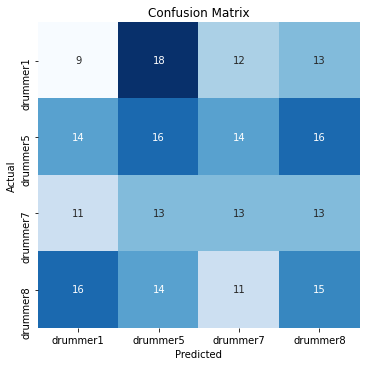

In [42]:
show_selected_styles()
dummy_res_1 = display_classify_results(y_test, y_pred, labels = np.unique(y))

In [ ]:
# write results to csv
dummy_res_1.to_csv('{}/_Results_Dummy_trainTestOnWholeDataset.csv'.format(home_dir))

# K-fold CV, manual loop thru pipes (OLD)

Compares..
* k=1-20
* 4 different pre-processing pipes

::TODO:: try different cv values.

In [ ]:
pca = PCA()

# list of ColumnTransformers setup earlier ..
cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]

results = []
best_score = 0
best_info = ''
best_pipe = None
best_k = 0

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=27)

for idx, ct in enumerate(cts):
  print("\n_______________________________________________________")
  print("\n>>>> pipe #{}.. \n".format(idx))
  
  # Calculating error for K values between 1 and 20
  for next_k in range(1, 20):
    next_pipe = Pipeline(steps=[('prep',ct), ('pca', pca), ('knn', KNeighborsClassifier(next_k))])
    cv_results = cross_val_score(next_pipe, X_train, y_train, cv=kf, scoring="accuracy", n_jobs=-1 )
    results.append(cv_results)

    # print out put of this run.
    this_mean = cv_results.mean()
    this_run = "pipe #{}, k={}, mean:{}".format(idx, next_k, this_mean)
    print('\n\n ___ '+this_run)
    cv_results

    # check for best
    if this_mean > best_score:
      best_score = this_mean
      best_info = this_run
      best_pipe = next_pipe
      best_k = next_k
    
print("\n\nBest score was > {}".format(best_score))
print(best_info)



## Training scores

In [ ]:
print('Best classifier k: {}, score: {}'.format(best_k, best_score))
print(best_info)
print('Best classifier pipe..')
best_pipe

## Testing scores

In [ ]:
#test_pipe = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
#test_pipe
_ = best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

In [ ]:
display_classify_results(y_test, y_pred, labels=np.unique(y))

Quick review of stats of the data we're about to use in the model search...

In [ ]:
X.describe()
pd.DataFrame(y).describe()
print('Drummers: {}'.format(np.unique(y)))
print('Beat positions: {}'.format(np.unique(X.bar_beat_number)))

# GridSearch, kNN

Good links!
* https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-cross-validation-and-hyperparameter-tuning/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-learn.org/stable/modules/compose.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

In [46]:
import sklearn
sklearn.__version__  # should be 0.23.2

'0.24.0'

Set data being used in 'Setup & select data...' > 'Song style selection''


In [47]:
# debug, show the data being worked on
show_selected_styles()

# collect our ColumnTransformers setup earlier ..
grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#grid_cts = [ct_v4]

param_grid_pca_yes = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
                     knn__p=[1, 2, 5], # knn distance functions to test
                     knn__weights=['uniform', 'distance'],
                     pca__n_components=[0.95, 2,3,4, None],
                     pca=[PCA()],
                     prep=grid_cts # list of ColTransformers to search
)

#param_grid_pca_no = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
#                     knn__p=[1, 2, 5], # knn distance functions to test
#                     knn__weights=['uniform', 'distance'],
#                     prep=grid_cts # list of ColTransformers to search
#)

# TMP next params setup only for efficiency, to reproduce clf with
# previously best found params.
# !!DELETE WHEN DONE!!
param_grid_pca_no = dict(knn__n_neighbors=np.arange(3, 5), # knn neighbours
                     knn__p=[2 ], # knn distance functions to test
                     knn__weights=['distance'],
                     prep=grid_cts # list of ColTransformers to search
)



#stratified for proportional class representation
skf = StratifiedKFold(n_splits=10)

my_pipe = Pipeline(steps=[('prep',None ), ('pca', None), ('knn', KNeighborsClassifier())])
#grid_search = GridSearchCV(my_pipe, param_grid=param_grid_pca_yes, cv=skf, verbose=2)
grid_search = GridSearchCV(my_pipe, param_grid=param_grid_pca_no, cv=skf, verbose=1)

print('\n___FITTING ....\n')
grid_search.fit(X_train,y_train)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)



 ====>>>> Working with data for style(s)... 
   ['hiphop/groove6']

___FITTING ....

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prep', None), ('pca', None),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([3, 4]), 'knn__p': [2],
                         'knn__weights': ['distance'],
                         'prep': [ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_robust',...
                                                                    'beat_offset']),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   ['note']),
                                                                  ('t_one_hot_styles',
                                                                   OneHotEncoder(categories=[['funk/groove1',
                                                                                              'soul/groove3',
                                                                                              'soul/groove4',
                                                                                              'hiphop/groove6',
                                                                                              'rock/groove8']],
                                                                                 drop='first'),
                                                                   ['style']),
                                                                  ('t_one_hot_beat_pos',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2,
                                                                                              3,
                                                                                              4,
                                                                                              5,
                                                                                              6,
                                                                                              7,
                                                                                              8,
                                                                                              9,
                                                                                              10,
                                                                                              11,
                                                                                              12,
                                                                                              13,
                                                                                              14,
                                                                                              15,
                                                                                              16]],
                                                                                 drop='first'),
                                                                   ['bar_beat_number'])])]},
             verbose=1)


___BEST ESTIMATOR



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity']),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  ['beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note']),
                                                 ('t_one_hot_styles',
                                                  OneHotEncoder(categories=[['funk/groove1',
                                                                             'soul/groove3',
                                                                             'soul/groove4',
                                                                             'hiphop/groove6',
                                                                             'rock/groove8']],
                                                                drop='first'),
                                                  ['style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('pca', None),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])


___BEST SCORE



0.7611613717652009


___BEST PARAMS



{'knn__n_neighbors': 4,
 'knn__p': 2,
 'knn__weights': 'distance',
 'prep': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('t_scaler_mm_1', MinMaxScaler(), ['velocity']),
                                 ('t_scaler_mm_2',
                                  MinMaxScaler(feature_range=(-0.5, 0.5)),
                                  ['beat_offset']),
                                 ('t_one_hot', OneHotEncoder(drop='first'),
                                  ['note']),
                                 ('t_one_hot_styles',
                                  OneHotEncoder(categories=[['funk/groove1',
                                                             'soul/groove3',
                                                             'soul/groove4',
                                                             'hiphop/groove6',
                                                             'rock/groove8']],
                                     

## Retrain the model
Notes that GridSearchCV does this by default with 'refit=True', but for our purposes here, it's useful to be able to retrain the best estimator on some different data (e.g. different song style) to see how it copes on a style by style basis.

Specific steps as follows ...

```
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)
prediction = best_clf.predict(X_new)
```


In [89]:
# extract best estimator
best_clf = grid_search.best_estimator_
best_clf

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity']),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  ['beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note']),
                                                 ('t_one_hot_styles',
                                                  OneHotEncoder(categories=[['funk/groove1',
                                                                             'soul/groove3',
                                                                             'soul/groove4',
                                                                             'hiphop/groove6',
                                                                             'rock/groove8']],
                                                                drop='first'),
                                                  ['style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('pca', None),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])

In [ ]:
# retrain if required
best_clf.fit(X_train, y_train)

## Now run best model with the test data ...

From the doc...
* GridSearchCV.predict(X_test) - Call predict on the estimator with the best found parameters.

NOTE: at this point, can use 'predict' to test with unseen data from *unseen styles* - useful test to if there's a fingerprint that transcends style.

In [97]:
# this is for regular train/ test split
#y_true, y_pred =  y_test, best_clf.predict(X_test)

# this is for train on one style, filter that style
# from the whole dataset, use what's left for testing
# (i.e. without doing any train/ test split)
y_true, y_pred = y, best_clf.predict(X)



 ====>>>> Working with data for style(s)... 
   ['funk/groove1' 'soul/groove3' 'soul/groove4' 'rock/groove8']

Accuracy score 0.35147392290249435

Classification report...
              precision    recall  f1-score   support

    drummer1       0.31      0.41      0.35      1138
    drummer5       0.39      0.41      0.40      1100
    drummer7       0.25      0.22      0.24      1055
    drummer8       0.47      0.36      0.41      1117

    accuracy                           0.35      4410
   macro avg       0.36      0.35      0.35      4410
weighted avg       0.36      0.35      0.35      4410


Confusion matrix...


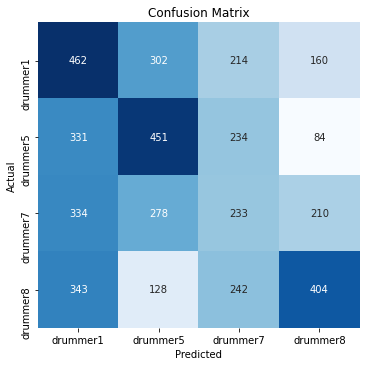

In [98]:
show_selected_styles()
knn_res_1 = display_classify_results(y_true=y_true, y_pred=y_pred, labels= np.unique(y_true))

In [95]:
results_dir = '{}LYIT/Dissertation/data/results/'.format(home_dir)
results_dir

# write results to csv
knn_res_1.to_csv('{}/_Results_kNN_trainOneStyleTestOtherStyles.csv'.format(results_dir))

'/content/drive/My Drive/LYIT/Dissertation/data/results/'

## ROC_AUC plots

See...
* https://stackoverflow.com/a/42392458/9930522
* https://github.com/reiinakano/scikit-plot


In [ ]:
!pip install scikit-plot


In [ ]:

from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)

# predicted probabilities generated by sklearn classifier
y_probas = grid_search.predict_proba(X_test)
_ = skplt.metrics.plot_roc_curve(y_true, y_probas)
_ = plt.show()

## Other metrics...
* https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules 

# GridSearch, kNN, manual loop

In [ ]:
# note: 'col_trans' is list of ColumnTransformers from earlier.
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#col_trans = [ct_v4]


param_grid_v1 = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
      knn__weights=['uniform', 'distance'],
      knn__p=[1, 2, 5] # knn distance functions to test
)


overall_best_score = 0
overall_best_classifier = None

skf = StratifiedKFold(n_splits=10)

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  my_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier())])
  grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v1, cv=skf, verbose=1)

  print('\n>>>>FITTING ....\n')
  _ = grid_search.fit(X_train,y_train)

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(grid_search.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(grid_search.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(grid_search.best_params_)

  if grid_search.best_score_ > overall_best_score:
    overall_best_score = grid_search.best_score_
    overall_best_classifier = grid_search




## Quick sanity check ...

In [ ]:

print('overall best_score: {}, classifier score:{}'.format(overall_best_score, overall_best_classifier.best_score_))
print('overall best classifier...')
overall_best_classifier
overall_best_classifier.best_params_
pd.DataFrame.from_dict(overall_best_classifier.cv_results_).head()

## Chart results 

In [ ]:
# this doesn't work with GridSearchCV results ...

grid_results = pd.DataFrame(grid_search.cv_results_['params'])
grid_results['test_score'] = grid_search.cv_results_['mean_test_score']

grid_results['metric'] = grid_results['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
grid_results.head()

In [ ]:

import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = grid_results[grid_results['metric'] == i]
    _ = plt.plot(temp['knn__n_neighbors'], temp['test_score'], marker = '.', label = i)
    
_ = plt.legend()
_ = plt.xlabel('Number of Neighbors')
_ = plt.ylabel("Mean CV Score")
_ = plt.title("KNN Performance Comparison")
plt.show()

## Run on test data

In [ ]:
y_pred = overall_best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

# Decision Tree

- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
- https://scikit-learn.org/stable/modules/tree.html

In [ ]:
X_train.describe()
X_train_prepped = ct_v4.fit_transform(X_train)

tmp_df1 = pd.DataFrame(X_train_prepped)
tmp_df1.head()


In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#tree_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
tree_clf = DecisionTreeClassifier(max_depth=4)


tree_clf.fit(X_train_prepped, y_train)
#tree.plot_tree(tree_clf) 


In [ ]:
from sklearn import metrics
X_test_prepped = ct_v4.fit_transform(X_test)
y_pred = tree_clf.predict(X_test_prepped)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

## GridSearchCV, DT

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=999)
dt_depth = list(np.arange(1, 20))

# can try modelling with scaling & dummies using previous setup ColTransformers...
#dt_prep_pipe = Pipeline(steps=[('prep',ct_v4), ('tree_clf', tree_clf)])

# apparently no scaling or dummies needed for DT
# new one to just encode 'note', leave everything else untouched
dt_enc_pipe = Pipeline(steps=[ ('enc', ct_ord_enc ), ('tree_clf', tree_clf)])

# setup param grid...
dt_params = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

# choose from dt_enc_pipe or dt_prep_pipe
my_clf = dt_enc_pipe

skf = StratifiedKFold(n_splits=10)

gscv_dt = GridSearchCV(estimator=my_clf, 
                     param_grid=dt_params, 
                     cv=skf,
                     verbose=1, 
                     scoring='accuracy')

gscv_dt.fit(X_train, y_train);

In [ ]:
gscv_dt.best_params_

In [ ]:
gscv_dt.best_score_

In [ ]:
results_DT = pd.DataFrame(gscv_dt.cv_results_['params'])
results_DT['test_score'] = gscv_dt.cv_results_['mean_test_score']
results_DT.columns

In [ ]:
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['tree_clf__criterion'] == i]
    temp_average = temp.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## GridSearchCV, DT, manual loop

In [ ]:
# list of ColumnTransformers setup previously
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4, ct_ord_enc ]
#col_trans = [ct_v4, ct_ord_enc ]

dt_depth = list(np.arange(1, 20))

dt_params_grid = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

overall_best_score = 0
overall_best_classifier2 = None

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  dt_pipe = Pipeline(steps=[('prep',ct), ('tree_clf', DecisionTreeClassifier(random_state=999))])
  gscv_dt = GridSearchCV(estimator=dt_pipe, 
                     param_grid=dt_params_grid, 
                     cv=10,
                     verbose=1, 
                     scoring='accuracy')

  print('\n>>>>FITTING ....\n')
  _ = gscv_dt.fit(X_train, y_train);

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(gscv_dt.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(gscv_dt.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(gscv_dt.best_params_)

  if gscv_dt.best_score_ > overall_best_score:
    overall_best_score = gscv_dt.best_score_
    overall_best_classifier2 = gscv_dt

Overall ...

In [ ]:
print('\n Overall .. BEST SCORE')
display(overall_best_classifier2.best_score_)

print('\n Overall .. BEST PARAMS')
display(overall_best_classifier2.best_params_)

## Chart results

In [ ]:
dt_results = pd.DataFrame(overall_best_classifier2.cv_results_['params'])
dt_results['test_score'] = overall_best_classifier2.cv_results_['mean_test_score']
dt_results.columns

In [ ]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (8,6)

for i in ['gini', 'entropy']:
    tmp_crit = dt_results[dt_results['tree_clf__criterion'] == i]
    tmp_avg = tmp_crit.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(tmp_avg, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## Run on test data

In [ ]:
y_pred = overall_best_classifier2.predict(X_test)
print(classification_report(y_test, y_pred))

# GradientBoostingClassifier

See...
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
* https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting


.. and..
* https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
* https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/


In [ ]:
sklearn.__version__  # should be 0.23.2

#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
  #max_depth=1, random_state=0).fit(X_train, y_train)
gbc_clf = GradientBoostingClassifier()


In [ ]:
show_selected_styles()

# note: 'grid_cts' is list of ColumnTransformers from earlier.
# list of ColumnTransformers setup earlier ..
grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#grid_cts = [ct_ord_enc ]
#grid_cts = [ct_v0, ct_v3, ct_v4]

param_grid_v0 = dict(
    gbc_clf__n_estimators=[50, 100, 250, 500, 1000], 
    gbc_clf__learning_rate=[0.1, 0.3, 0.5], 
    gbc_clf__max_depth=[3, 5, 7], 
    gbc_clf__random_state=[0],
    gbc_clf__max_features=['auto'], 
    prep=grid_cts # list of ColTransformers to search
)

# reduced params, based on previous tests
param_grid_v1 = dict(
    gbc_clf__n_estimators=[ 100, 250, 500, 1000], 
    gbc_clf__learning_rate=[0.1, 0.3], 
    gbc_clf__max_depth=[3, 5, 7], 
    gbc_clf__random_state=[0],
    gbc_clf__max_features=['auto'], 
    prep=grid_cts # list of ColTransformers to search
)

# search all pipes in grid_cts
my_pipe = Pipeline(steps=[('prep',None), ('gbc_clf', gbc_clf)])
#grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v0, cv=10, verbose=2)
grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v1, cv=10, verbose=2)

print('\n>>>>FITTING ....\n')
grid_search.fit(X_train,y_train)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)




In [ ]:
show_selected_styles()

## Retrain the model
Notes that GridSearchCV does this by default with 'refit=True', but for our purposes here, it's useful to be able to retrain the best estimator on some different data (e.g. different song style) to see how it copes on a style by style basis.

Specific steps as follows ...

```
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)
prediction = best_clf.predict(X_new)
```


In [ ]:
# extract best estimator
best_clf = grid_search.best_estimator_

In [ ]:
# retrain if required, e.g. testing on different data
best_clf.fit(X_train, y_train)

In [ ]:
y_true, y_pred =  y_test, best_clf.predict(X_test)

# this is for train on one style, filter that style
# from the whole dataset, use what's left for testing
# (i.e. without doing any train/ test split)
#y_true, y_pred =  y, best_clf.predict(X) 

show_selected_styles()
res_1 = display_classify_results(y_true=y_true, y_pred=y_pred, labels= np.unique(y))



In [ ]:
# write results to csv
res_1.to_csv('{}/_Results_GBC_trainStyle6TestAcrossRest_groove8.csv'.format(home_dir))

# Misc other classifiers (TODO)

In [ ]:
this is a deliberate error to stop processing ...

## SVM with RBF

* https://scikit-learn.org/stable/modules/svm.html#classification
* https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [ ]:
from sklearn.svm import SVC

In [ ]:
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.
#C_range = np.logspace(-2, 10, 13)
C_range = np.logspace(-2, 10, 3)
#gamma_range = np.logspace(-9, 3, 13)
gamma_range = np.logspace(-9, 3, 3)


In [ ]:

print('C range: {}'.format(C_range))
print('Gamma range: {}'.format(gamma_range))

# list of ColumnTransformers setup previously
#col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
col_trans = [ct_v0]



svm_params_grid = {'svc_clf__gamma': gamma_range,
                  'svc_clf__C': C_range}

overall_best_score = 0
overall_best_classifier3 = None

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  svm_pipe = Pipeline(steps=[('prep',ct), ('svc_clf', SVC(kernel='rbf'))])
  gscv_svm = GridSearchCV(estimator=svm_pipe, 
                     param_grid=svm_params_grid, 
                     cv=5,
                     verbose=1, 
                     scoring='accuracy')

  print('\n>>>>FITTING ....\n')
  _ = gscv_svm.fit(X_train, y_train);

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(gscv_svm.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(gscv_svm.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(gscv_svm.best_params_)

  if gscv_svm.best_score_ > overall_best_score:
    overall_best_score = gscv_svm.best_score_
    overall_best_classifier3 = gscv_svm

.... waiting on that last cell to complete!!!!!

## VotingClassifier

Review classifiers so far...

In [ ]:
overall_best_classifier.best_estimator_
overall_best_classifier2.best_estimator_
overall_best_classifier3.best_estimator_

Create a voting ensemble aggregate of all prior best classifiers...

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

eclf = VotingClassifier(estimators=[('knn', overall_best_classifier.best_estimator_), 
                                    ('dt', overall_best_classifier2.best_estimator_), 
                                    ('svm', overall_best_classifier3.best_estimator_), 
                                    ],voting='hard')

In [ ]:
for clf, label in zip([overall_best_classifier.best_estimator_, 
                       overall_best_classifier2.best_estimator_, 
                       overall_best_classifier3.best_estimator_, 
                       eclf],
                      ['KNN', 'DT', 'SVM', 'Ensemble']):
  scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

# Compile Results

In [ ]:

results_dir = '{}LYIT/Dissertation/data/results/'.format(home_dir)
results_dir

In [ ]:
import glob

# loads files based on filename pattern
def pd_read_pattern(pattern):
  files = glob.glob(pattern)

  df = pd.DataFrame()
  for f in files:
      next_df = pd.read_csv(f)
      clf_type = f.split('_Results_')[1].split('_')[0]
      next_df['model'] = clf_type

      if f.find('TestAcrossRest_') != -1:
        style_type = f.split('TestAcrossRest_')[1].split('.csv')[0]
        next_df['style'] = style_type

      df = df.append(next_df)

  return df.reset_index(drop=True)


## Classifier Summary Results

In [ ]:
df = pd_read_pattern('{}/_Results*trainTestOnWholeDataset.csv'.format(results_dir))

In [ ]:
df_tmp = df.copy(deep=True)

In [ ]:
# rename 1st col
df_tmp = df_tmp.rename(columns={ df.columns[0]: "thing" })

# drop cols: precision, recall, support
df_tmp = df_tmp.drop(columns=['precision', 'recall', 'support'])

# drop rows: accuracy, macro avg
df_tmp = df_tmp.loc[~df_tmp.thing.isin(['accuracy','macro avg'])]

In [ ]:
df_tmp.head()

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_tmp, kind="bar",
    x="thing", y="f1-score", hue="model",
    ci=None, palette="colorblind", alpha=.8, height=4, aspect=2
)
_ = g.despine(left=True)
_ = g.set_axis_labels("", "f1-score")
_ = plt.suptitle("Drummer Identification Scores")
_ = g.legend.set_title("Classifiers")

## Classifier Results by Style

In [ ]:
df = pd_read_pattern('{}/_Results*trainStyle6TestAcrossRest*'.format(results_dir))

In [ ]:
df_tmp = df.copy(deep=True)

In [ ]:
# rename 1st col
df_tmp = df_tmp.rename(columns={ df.columns[0]: "thing" })

# drop cols: precision, recall, support
df_tmp = df_tmp.drop(columns=['precision', 'recall', 'support'])

# drop rows: accuracy, macro avg
df_tmp = df_tmp.loc[~df_tmp.thing.isin(['accuracy','macro avg'])]

In [ ]:

df_tmp.replace(inplace=True, to_replace={'style': {'groove1': 'funk/groove1', 
                                                   'groove3': 'soul/groove3', 
                                                   'groove4':'soul/groove4', 
                                                   'groove6':'hiphop/groove6', 
                                                   'groove8':'rock/groove8'}})

In [ ]:
df_tmp.head()

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_tmp, kind="bar",
    #x="thing", y="f1-score", hue="style", col="model", col_wrap=1,
    x="style", y="f1-score", hue="thing", col="model", col_wrap=1,
    #x="thing", y="f1-score", hue="model", col="style", col_wrap=1,
    ci=None, palette="colorblind", alpha=.8, height=4, aspect=2
)
_ = g.despine(left=True)
_ = g.set_axis_labels("", "f1-score")
_ = plt.subplots_adjust(top=0.9)
_ = plt.suptitle("Drummer Identification Scores")
_ = g.legend.set_title("Class")